# Variation Autoencoder for MNIST



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [3]:
# ハイパーパラメータ
batch_size = 128
latent_dim = 2  # 中間層の次元
epochs = 50
learning_rate = 1e-3
beta = 1.0  # KLダイバージェンスの重み

# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [4]:
# VAEモデルの定義
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



Epoch 1, Loss: 56.6435
Epoch 2, Loss: 43.2024
Epoch 3, Loss: 41.2387
Epoch 4, Loss: 40.1747
Epoch 5, Loss: 39.4667
Epoch 6, Loss: 39.0108
Epoch 7, Loss: 38.6834
Epoch 8, Loss: 38.4061
Epoch 9, Loss: 38.1784
Epoch 10, Loss: 38.0324
Epoch 11, Loss: 37.8401
Epoch 12, Loss: 37.7116
Epoch 13, Loss: 37.5637
Epoch 14, Loss: 37.4519
Epoch 15, Loss: 37.3453
Epoch 16, Loss: 37.2176
Epoch 17, Loss: 37.1121
Epoch 18, Loss: 37.0428
Epoch 19, Loss: 36.9508
Epoch 20, Loss: 36.8600
Epoch 21, Loss: 36.7815
Epoch 22, Loss: 36.7204
Epoch 23, Loss: 36.6273
Epoch 24, Loss: 36.5669
Epoch 25, Loss: 36.5021
Epoch 26, Loss: 36.4165
Epoch 27, Loss: 36.3914
Epoch 28, Loss: 36.3108
Epoch 29, Loss: 36.2758
Epoch 30, Loss: 36.2142
Epoch 31, Loss: 36.1700
Epoch 32, Loss: 36.1173
Epoch 33, Loss: 36.0594
Epoch 34, Loss: 36.0241
Epoch 35, Loss: 35.9897
Epoch 36, Loss: 35.9504
Epoch 37, Loss: 35.9089
Epoch 38, Loss: 35.8645
Epoch 39, Loss: 35.8123
Epoch 40, Loss: 35.7878
Epoch 41, Loss: 35.7518
Epoch 42, Loss: 35.7374
E

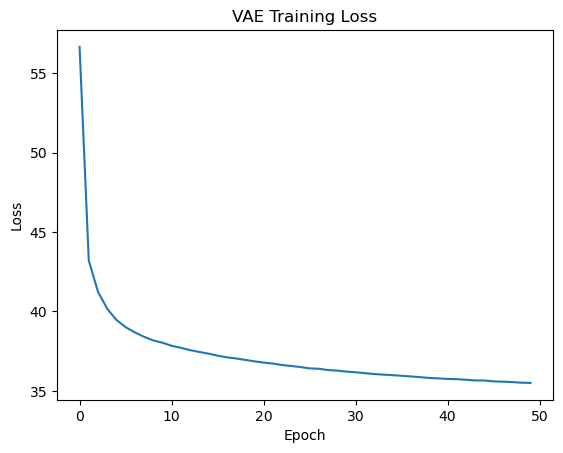

In [5]:
# モデル、損失関数、最適化手法の定義
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*KLD

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [11]:
# MSE loss の計算
def calculate_mse_loss(model, data_loader):
    model.eval()
    mse_loss = 0.0
    with torch.no_grad():
        for data, _ in data_loader:
            recon_batch, _, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon_batch.view(-1, 784), data.view(-1, 784), reduction='sum')
    return mse_loss / len(data_loader.dataset)
# MSE loss の計算
mse_loss = calculate_mse_loss(model, train_loader)
print(f'MSE Loss: {mse_loss:.4f}')

MSE Loss: 30.2667


z_list shape: (60000, 2)


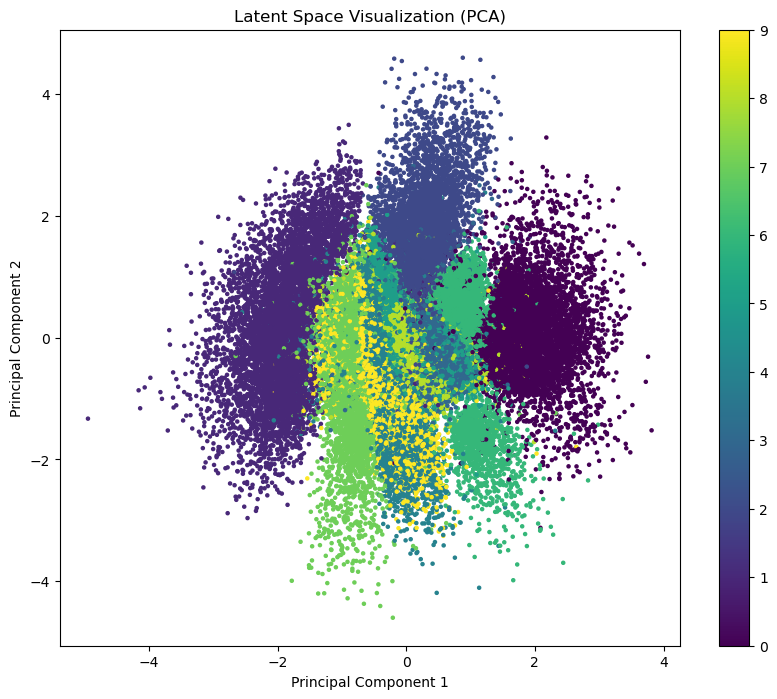

In [12]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

print(f"z_list shape: {z_list.shape}")

# PCAを使用して次元削減
#pca = PCA(n_components=2)
#z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_list[:, 0], z_list[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



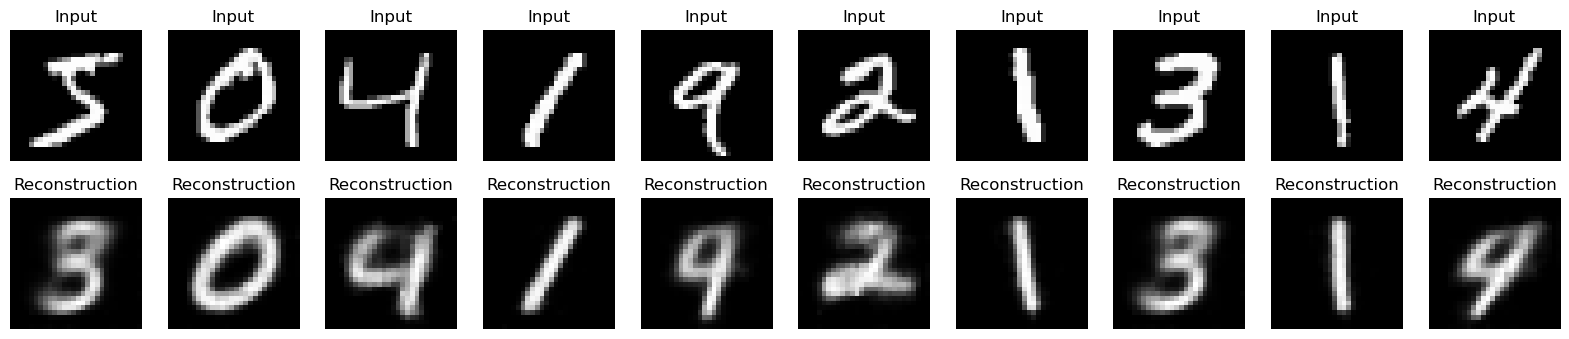

In [13]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        recon_sample, _, _ = model(sample)
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()